In [1]:
import pandas as pd
import numpy as np
import collections
import datetime
import time
from github import Github, RateLimitExceededException
import os
import itertools
import seaborn as sns
import io
from dotenv import load_dotenv, find_dotenv
import boto3

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
g = Github(os.getenv("GITHUB_ACCESS_TOKEN"))

In [4]:
name = os.getenv("REPO_NAME")

if "/" in name:
    REPO = name
    USER = ""
else:
    USER = name
    REPO = ""

In [5]:
# whether to use ceph or store locally

use_ceph = True

if use_ceph:
    s3_endpoint_url = os.environ["OBJECT_STORAGE_ENDPOINT_URL"]
    s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
    s3_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]
    s3_bucket = os.environ["OBJECT_STORAGE_BUCKET_NAME"]

    s3 = boto3.client(
        service_name="s3",
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
        endpoint_url=s3_endpoint_url,
    )

In [6]:
# add all repos to list, or create list of one
repos_ = []

if USER:
    org = g.get_user(USER)
    repos = org.get_repos()
    for repo in repos:
        repos_.append(repo)
else:
    to_add = g.get_repo(REPO)
    repos_.append(to_add)

In [7]:
def get_issues_for_repo(repo):
    """
    takes in a pygithub repo object and returns the list of pygithub issue objects
    """
    issues = []
    issues_left = True
    max_date = datetime.datetime.min
    while issues_left:
        issues_left = False
        try:
            for issue in repo.get_issues(state="all", direction="asc", since=max_date):
                max_date = issue.created_at
                if issue.pull_request is None:
                    issues.append(issue)
        except RateLimitExceededException:
            # rate limit exception
            print(len(issues), "issues added for", {repo.full_name})
            print("SLEEPING NOW FOR AN HOUR")
            time.sleep(60 * 61)
            issues_left = True
    return issues

In [8]:
# add in all issues
all_issues = {}

if USER:
    print("getting issues for repos")
    for repo in repos_:
        all_issues[repo.full_name] = get_issues_for_repo(repo)
else:
    repo = repos_[0]
    all_issues[repo.full_name] = get_issues_for_repo(repo)

total_issues = sum([len(b) for a, b in all_issues.items()])
print(total_issues, "total issues")

2834 total issues


In [9]:
# create a dataframe for issues

issue_data = []

for repo, issues in all_issues.items():
    for issue in issues:
        labels = [lbl.name for lbl in issue.labels]
        label_names = "\t".join(labels) if labels else np.nan
        id_ = repo + "/" + str(issue.number)
        data = [
            id_,
            repo,
            issue.title,
            issue.body,
            issue.created_at,
            issue.user.login,
            len(labels),
            label_names,
        ]
        issue_data.append(data)
cols = [
    "id",
    "repo",
    "title",
    "body",
    "created_at",
    "created_by",
    "num_labels",
    "labels",
]
issues_df = pd.DataFrame(issue_data, columns=cols)

In [10]:
# show issues dataframe
issues_df.sample(5)

,id,repo,title,body,created_at,created_by,num_labels,labels
569,pytorch/fairseq/936,pytorch/fairseq,Small errors in preprocessing script for GLUE ...,"Hi,\r\n\r\nI try to fine-tune the roberta mode...",2019-07-31 09:09:50,villmow,0,NaN
2502,pytorch/fairseq/3371,pytorch/fairseq,[Question] wav2vec 2.0 timestamp words,Is it possible to extract the Words start time...,2021-03-18 23:12:54,irux,3,needs triage\tquestion\tstale
1686,pytorch/fairseq/2378,pytorch/fairseq,How to set classification_head_name in roberta,## ❓ Questions and Help\r\n\r\n#### What is yo...,2020-07-27 10:53:03,xu-song,2,needs triage\tquestion
2007,pytorch/fairseq/2766,pytorch/fairseq,M2M Corpus Inclusion?,This is really just feedback for the authors o...,2020-10-21 11:06:12,normanhh3,0,NaN
1649,pytorch/fairseq/2330,pytorch/fairseq,Document missing?,## 📚 Documentation\r\n\r\nIt seems that some d...,2020-07-15 08:21:09,butsugiri,2,documentation\tneeds triage


In [11]:
# view most common labels

label_lst = list(
    itertools.chain.from_iterable([ls.split("\t") for ls in issues_df.labels.dropna()])
)
counter = collections.Counter(label_lst)

counter.most_common(20)

[('question', 1178),
 ('needs triage', 987),
 ('stale', 463),
 ('bug', 401),
 ('enhancement', 167),
 ('help wanted', 146),
 ('documentation', 85),
 ('speech-to-text', 42),
 ('windows', 26),
 ('unable to repro', 26),
 ('wav2vec', 9),
 ('BART/mBART', 4),
 ('cleanup', 3),
 ('0.10.2', 2),
 ('M2M-100', 2),
 ('LayerDrop', 1),
 ('python3.9', 1),
 ('translation', 1),
 ('paraphraser', 1),
 ('DynamicConv/LightConv', 1)]

In [12]:
# view most common issue creators

issues_df.created_by.value_counts()[:20]

shamanez          31
erip              27
gaopengcuhk       20
ajesujoba         20
astariul          18
nicolabertoldi    17
travel-go         16
tuhinjubcse       16
munael            16
gvskalyan         15
villmow           15
MrityunjoyS       14
getao             14
aastha19          13
haorannlp         13
ghost             13
14H034160212      13
ismymajia         12
louismartin       11
sshleifer         11
Name: created_by, dtype: int64

(0.0, 6.0)

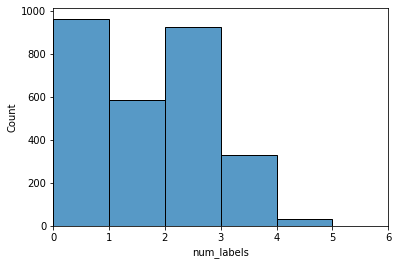

In [13]:
# view distribution of the number of issues in a label

ax = sns.histplot(issues_df.num_labels, bins=int(max(issues_df.num_labels)))
ax.set_xlim((0, 6))

In [14]:
# save dataframe
savename = USER if USER else REPO.replace("/", "-_-")

if use_ceph:
    with io.StringIO() as csv_buffer:
        issues_df.to_csv(csv_buffer, index=False)

        response = s3.put_object(
            Bucket=s3_bucket, Key=f"data/{savename}.csv", Body=csv_buffer.getvalue()
        )
else:
    issues_df.to_csv(os.path.join("../../data", savename + ".csv"), index=None)